Создание данных для задач uplift классификации

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from causalml.dataset import make_uplift_classification

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to import duecredit due to No module named 'duecredit'


Фиксация случайностей

In [3]:
RANDOM_STATE = 42

Генерация данных

In [4]:
df, x_names = make_uplift_classification(treatment_name = ['0', '1'],
                                         y_name = 'target',
                                         n_classification_features = 8,
                                         n_classification_informative = 5,
                                         n_samples = 20000,
                                         random_seed = RANDOM_STATE)
df = df.drop(columns='treatment_effect')
df.treatment_group_key = df.treatment_group_key.astype('int')

In [5]:
df.head(5)

,treatment_group_key,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_irrelevant,x7_irrelevant,x8_irrelevant,target
0,1,-1.396408,-1.503843,-0.697099,0.727533,-0.123785,0.105524,-1.662881,-0.194119,0
1,0,2.622423,-0.373192,2.387157,-3.732785,-0.386560,0.914045,-1.821806,1.294757,0
2,1,1.195191,-0.026724,0.313481,0.306222,-0.675433,1.617729,-0.020601,0.258099,0
3,0,2.833813,-0.729516,3.298961,-1.495414,0.416893,-0.997067,0.155180,-0.770831,0
4,1,2.156778,-2.114360,-1.521590,-0.128608,-0.294361,-0.188140,-1.860909,0.598018,1


Создал датасет с восемью признаками (x1 - x8), флагом коммуникации (treatment_group_key, в данном случае 0, если коммуникация отсутствует, 1 если коммуникация направлена) и бинарным таргетом.

Анализ данных

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   treatment_group_key  40000 non-null  int64  
 1   x1_informative       40000 non-null  float64
 2   x2_informative       40000 non-null  float64
 3   x3_informative       40000 non-null  float64
 4   x4_informative       40000 non-null  float64
 5   x5_informative       40000 non-null  float64
 6   x6_irrelevant        40000 non-null  float64
 7   x7_irrelevant        40000 non-null  float64
 8   x8_irrelevant        40000 non-null  float64
 9   target               40000 non-null  int64  
dtypes: float64(8), int64(2)
memory usage: 3.1 MB


Проверяю, насколько разбиение на контрольную и целевую группу однородно. Разбиение на контрольную и целевую группу должно быть однородно, то есть попадание в эти группы не должно никак зависеть от характеристик объекта, т.е. быть случайным.

In [7]:
df.groupby(by='treatment_group_key').mean()

,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_irrelevant,x7_irrelevant,x8_irrelevant,target
treatment_group_key,,,,,,,,,
0,1.008541,-0.989406,0.003820,-1.004891,0.009619,0.003291,-0.000394,0.000316,0.50085
1,1.004150,-1.002352,0.003388,-1.010594,-0.009012,0.004278,-0.007239,-0.013988,0.49955


Среднее значение каждого признака в целевой и контрольной группе

Гистограммы распределения признаков в зависимости от того, в какую группу попал признак

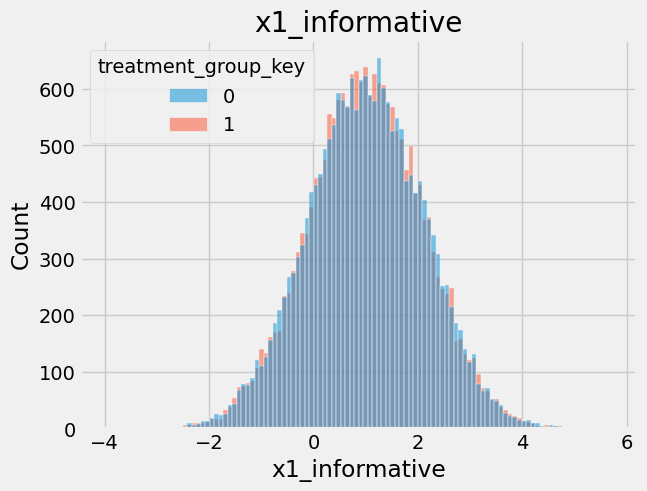

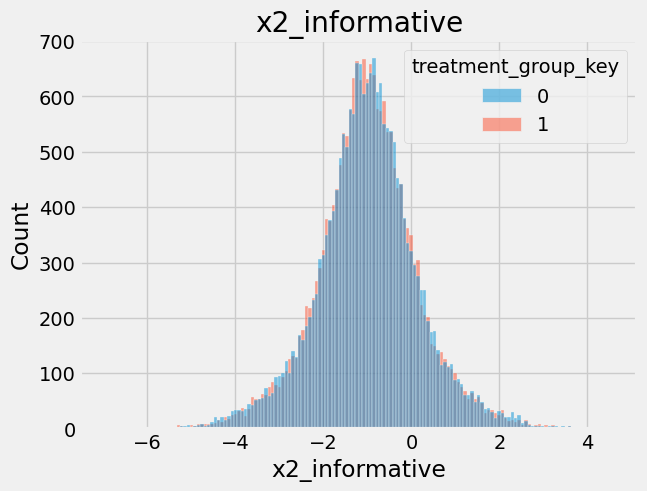

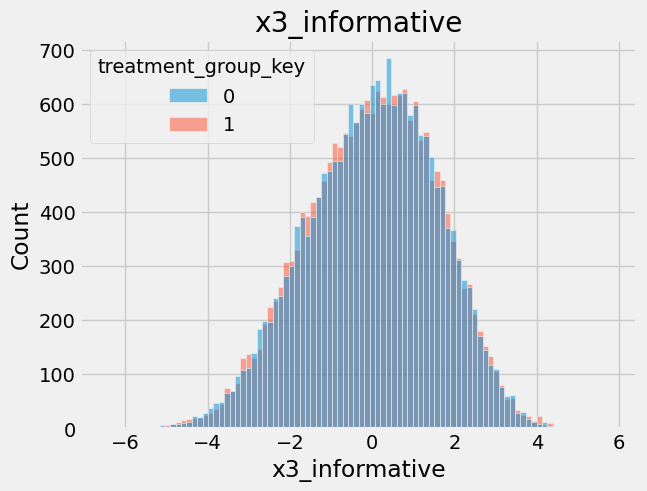

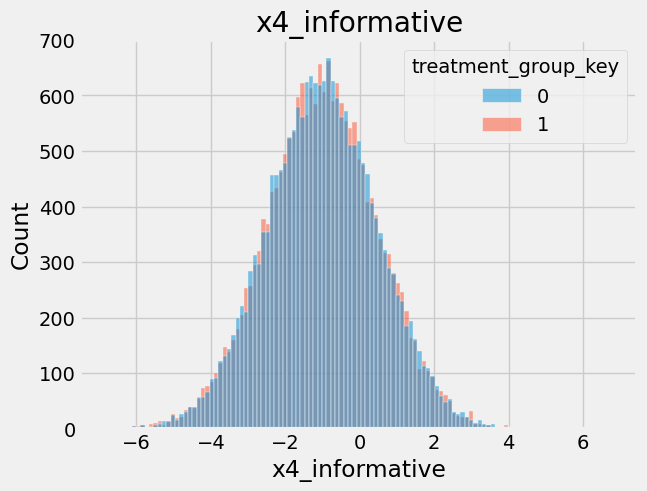

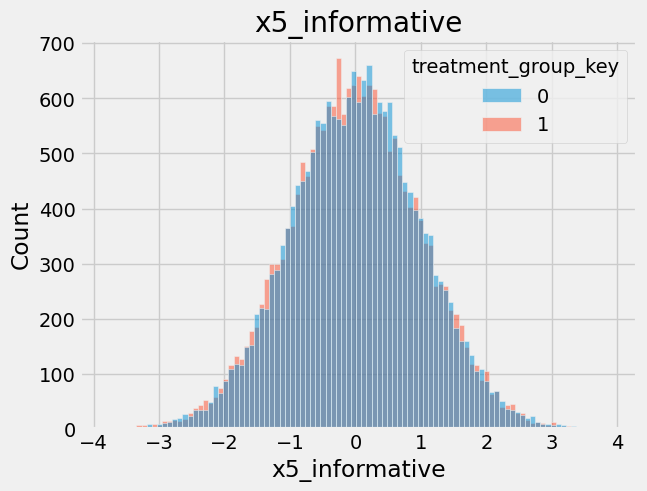

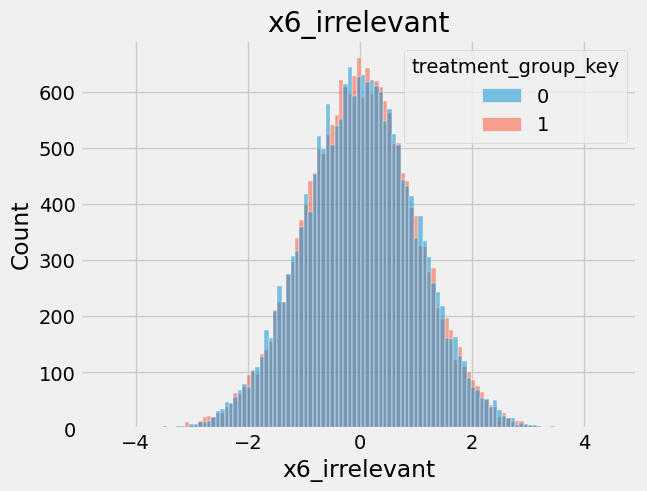

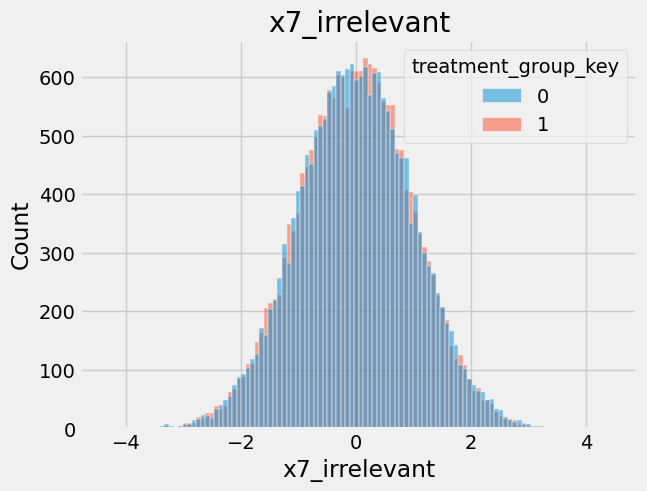

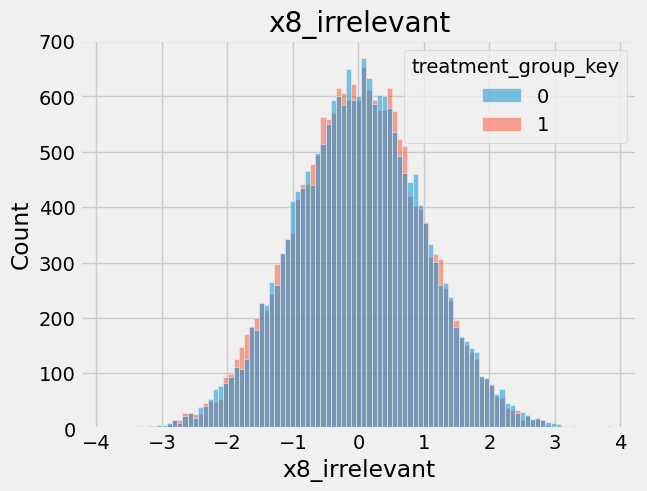

In [8]:
for col in x_names:
    sns.histplot(data = df, x=col, hue='treatment_group_key').set_title(col)
    plt.show()

Разбиваю данные на тестовую и тренировочную части

In [9]:
train_index, test_index = train_test_split(df.index, test_size=0.25, random_state=RANDOM_STATE)

Обучение модели

1. Обучим модель на X_train (с колонкой с флагом коммуникации)
2. Для построения предсказаний (predict_proba) uplift подадим X_test дважды - сначала указав в качестве флага коммуникации 0, а затем указав в качестве флага коммуникации 1

In [10]:
X_train = df.loc[train_index].drop(columns = 'target')
y_train = df.loc[train_index].target
X_test = df.loc[test_index].drop(columns = 'target')
y_test = df.loc[test_index].target

Линейная модель классификации

In [11]:
model = LogisticRegression(random_state=RANDOM_STATE)

Обучение модели на тренировочных данных

In [12]:
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


Не показываем рекламу никому из клиентов

In [13]:
X_test_0 = X_test.copy()
X_test_0['treatment_group_key'] = 0
X_test_0.head()

,treatment_group_key,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_irrelevant,x7_irrelevant,x8_irrelevant
32823,0,1.558881,-0.279099,-1.171773,-1.779082,-0.766971,-0.617859,0.986989,0.301869
16298,0,0.018831,-0.783363,0.707355,-2.846963,-1.769417,0.605445,0.173402,-0.151209
28505,0,2.033002,0.694059,-1.422458,-0.453822,2.276806,2.356658,1.019202,-0.509294
6689,0,1.085044,-0.584606,0.823661,-1.333769,-1.032043,-1.565472,-1.585665,0.210667
26893,0,1.058238,-1.143801,0.982797,-1.811322,-0.493691,0.167439,-1.337518,1.447407


Прогноз вероятности покупки товара

In [14]:
y_pred_0 = model.predict_proba(X_test_0)[:,1]

y_pred_0[:10]

array([0.98554726, 0.46432232, 0.97759662, 0.19683314, 0.20321801,
       0.91946629, 0.01212497, 0.26488565, 0.8252954 , 0.98564371])

Показываем рекламу всем клиентам

In [15]:
X_test_1 = X_test.copy()
X_test_1['treatment_group_key'] = 1
X_test_1.head()

,treatment_group_key,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_irrelevant,x7_irrelevant,x8_irrelevant
32823,1,1.558881,-0.279099,-1.171773,-1.779082,-0.766971,-0.617859,0.986989,0.301869
16298,1,0.018831,-0.783363,0.707355,-2.846963,-1.769417,0.605445,0.173402,-0.151209
28505,1,2.033002,0.694059,-1.422458,-0.453822,2.276806,2.356658,1.019202,-0.509294
6689,1,1.085044,-0.584606,0.823661,-1.333769,-1.032043,-1.565472,-1.585665,0.210667
26893,1,1.058238,-1.143801,0.982797,-1.811322,-0.493691,0.167439,-1.337518,1.447407


Прогноз вероятности покупки товара

In [16]:
y_pred_1 = model.predict_proba(X_test_1)[:,1]

y_pred_1[:10]

array([0.98543827, 0.46242671, 0.97742905, 0.19563075, 0.20198643,
       0.91889999, 0.012034  , 0.26340389, 0.82419351, 0.98553544])

Вычисляю UPLIFT

In [17]:
uplift = y_pred_1 - y_pred_0

Анализ результатов

In [18]:
uplift_pd = pd.DataFrame(data = uplift, index = X_test.index, columns=['uplift'])
uplift_pd = uplift_pd.sort_values(by='uplift', ascending=False)

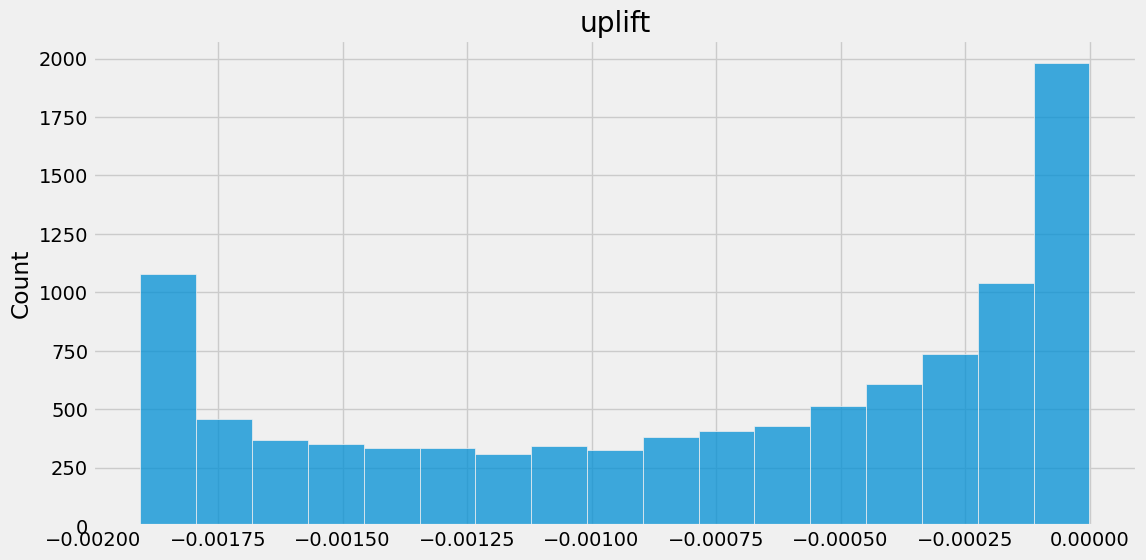

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data = uplift_pd, x=uplift).set_title('uplift')
plt.show()

Сами прогнозы

In [20]:
uplift_pd.head()

,uplift
16858,-2.936244e-07
8925,-3.386658e-07
2149,-4.470017e-07
16085,-4.808762e-07
12249,-6.515952e-07
